In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Maps
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#Datas
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

bnb = pd.read_csv("listings_dec18.csv")
bnb["price"] = bnb["price"].astype(str).str.strip("$").str.replace(",","").astype(float)
bnb["weekly_price"] = bnb["weekly_price"].astype(str).str.strip("$").str.replace(",","").astype(float)
bnb["cleaning_fee"] = bnb["cleaning_fee"].astype(str).str.strip("$").str.replace(",","").astype(float)

hm = bnb[["id", "host_id", "property_type", "room_type", "accommodates", "bedrooms", "beds","price", "weekly_price","cleaning_fee", "reviews_per_month", "review_scores_value"]]
hm["room_type"] = hm["room_type"].map({'Entire home/apt':3, 'Private room':2, 'Shared room':1})
hm["property_type"] = hm["property_type"].map({'Apartment':10, 'House ':9, 'Townhouse':8, 'Condominium':7, 'Serviced apartment':6,'Villa':5,
                'Guesthouse':4, 'Bed and breakfast':3,'Guest suite':2, 'Loft':1, 'Rare':0})



reviews = pd.read_csv("reviews_dec18.csv")
reviews["comments"] = reviews["comments"].str.replace("\r", "").str.replace("\n", " ")
text = reviews.sort_values(by = ["listing_id"]).groupby("listing_id").apply(lambda x: x.sum()).unstack().drop(columns=["listing_id"]).reset_index()

availability = pd.read_csv("calendar_dec18.csv")
availability["price"] = availability["price"].str.lstrip("$").str.replace(",","").astype(float)
occupiedFree = availability.rename(columns={'available': 'Available'})\
                .groupby(["date","Available"])["listing_id"]\
                .count()\
                .unstack().reset_index().rename(columns={'t': 'Occupied', 'f': 'Free'})
months = pd.DatetimeIndex(availability.dropna()["date"]).to_period("M")

latitude = bnb["latitude"]
longitude = bnb["longitude"]

priceMean = pd.DataFrame(availability.groupby("listing_id")["price"].mean()).reset_index()
score = pd.merge(bnb[["id", "review_scores_rating", "number_of_reviews"]], priceMean, how="inner", left_on="id", right_on="listing_id").drop(['listing_id'], axis = 1)

C:\Users\remib\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\remib\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\remib\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
#Graph prep

graph11 = bnb.groupby("room_type")["id"].count().sort_values(ascending = True)
graph12 = bnb.groupby("city")["id"].count().sort_values(ascending=False).head(15)
graph13 = bnb.groupby("room_type")["id"].count().sort_values(ascending = True)


graph21 = bnb[bnb["accommodates"] <= 6].groupby("accommodates")["price"].mean().sort_values(ascending = True)

graph22= reviews.set_index("date").groupby(pd.DatetimeIndex(reviews["date"]).to_period("Y"))["id"].count()
graph22.index = [i.year for i in reviews.set_index("date").groupby(pd.DatetimeIndex(reviews["date"]).to_period("Y"))["id"].count().keys()]

graph23= reviews.set_index("date").groupby([pd.DatetimeIndex(reviews["date"]).to_period("Y")])["reviewer_id"].nunique()
graph23.index = [i.year for i in reviews.set_index("date").groupby(pd.DatetimeIndex(reviews["date"]).to_period("Y"))["reviewer_id"].count().keys()]

graph24 = score["price"]
graph24.index = score["review_scores_rating"]
graph24Colors = score["number_of_reviews"]
graph24Size = score["number_of_reviews"]/score["number_of_reviews"].max()*50+10
graph24YMax = bnb[np.abs(bnb["price"]-bnb["price"].mean()) <= (3*bnb["price"].std())]["price"]

graph25 = bnb[bnb["accommodates"] <= 6].groupby("accommodates")["price"].mean()


In [4]:
#Interactive graph

tmp = pd.merge(bnb, reviews, left_on='id', right_on='listing_id')
tmp["year"] = pd.to_datetime(reviews["date"]).dt.year.astype(int)
x = pd.DataFrame()
#x["year"] = tmp["year"]#pd.to_datetime(tmp).dt.year.astype(int)
x["price"] = tmp.groupby([tmp["year"], tmp["city"]])["price"].mean()
x["visitor"] = tmp.groupby([tmp["year"], tmp["city"]])["listing_id"].count()
x = x.reset_index()
liste = tmp.groupby("city")["id_y"].count().sort_values(ascending = False).head(10)
x = x[x["city"].isin(liste.index)]
x["size"] = [500 for i in range(0,len(x))]

In [5]:
def createWordCloud(id):
    t = text["comments"][ text[text["listing_id"] == id ].index[0] ]
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["Melbourne"])

    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(t)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.show()
    wordcloud.to_file('testplot.png')
    return plt

In [6]:
#Images

import base64
with open("testplot.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()
encoded_image = "data:image/png;base64," + encoded_string

with open("airbnblogo.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
encoded_image2 = "data:image/png;base64," + encoded_string2

with open("airbnb.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
airbnbLogo = "data:image/png;base64," + encoded_string2

with open("host.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
hostLogo = "data:image/png;base64," + encoded_string2

with open("superHost.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
superHostLogo = "data:image/png;base64," + encoded_string2

with open("visitor.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
visitorLogo = "data:image/png;base64," + encoded_string2

with open("review.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
reviewLogo = "data:image/png;base64," + encoded_string2

with open("tourism.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
tourismLogo = "data:image/png;base64," + encoded_string2

with open("market.png", "rb") as image_file:
    encoded_string2 = base64.b64encode(image_file.read()).decode()
marketLogo = "data:image/png;base64," + encoded_string2


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Mar/2019 11:57:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:57:58] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:57:58] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:16] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:16] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:17] "GET /_favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2019 11:58:

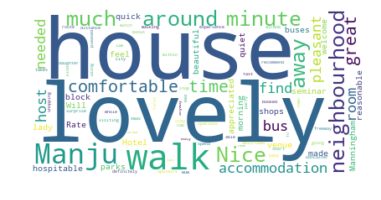

In [7]:
# -*- coding: utf-8 -*-
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import flask
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

mapbox_access_token = 'pk.eyJ1IjoicmVtaXRlam8iLCJhIjoiY2p0bjVsdndvMDRhOTQ1bXI3MnJxZzN5NyJ9._z5lekWQreLkWcjvuIXdDg'

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css', 'https://getbootstrap.com/docs/4.3/dist/css/bootstrap.min.css']
server = flask.Flask("app")
app = dash.Dash('app', server=server, external_stylesheets=external_stylesheets)
app.config['suppress_callback_exceptions']=True


app.layout = html.Div([
    html.Div([
        html.Div([
            html.Div([html.Img(id= "Logo", src=encoded_image2, style = {"max-width":"80%","max-height":"80%", "margin":"3%","text-align": "center"})]),
            html.Div([html.H1("Melbourne Airbnb Market", style={"text-align": "center", "vertical-align": "middle","margin" : "3%", "margin-bottom":"20%","margin-top":"15%"})]),
            html.Div([
                html.Div([
                    html.Ul([
                        html.Li([
                            html.A([#html.Div(["Tourists"])
                                html.Div([
                                    html.Img(src=tourismLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                                ], className = "text-center"),
                                html.Div([
                                    html.H3("Tourism", style={"vertical-align": "middle","margin" : "3%"})
                                ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)","text-align": "center"})
                            ],className = "list-group-item list-group-item-action",n_clicks_timestamp=0, id = "Tourists")
                        ]),
                        html.Li([
                            html.A([
                                html.Div([
                                    html.Img(src=marketLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                                ], className = "text-center"),
                                html.Div([
                                    html.H3("Airbnb Market", style={"vertical-align": "middle","margin" : "3%"})
                                ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)","text-align": "center"})
                            ] ,className = "list-group-item list-group-item-action",n_clicks_timestamp=0, id = "Lenders")
                        ])
                    ],className = "nav-item list-group",style={"font-size":"150%","list-style-type":"none"})
                ])
            ],className = "nav flex-column")
        ], className = "sidebar-sticky sticky-top", style={"height":"100vh"})
                
    ], className = "col-md-2 d-none d-md-block bg-light sidebar container-fluid "),
    
    html.Div([
        html.Div(id='tabs-content'),
    ], className = "container-fluid col-md-9 ml-sm-auto col-lg-10 px-4")
], className = "row container-fluid")


#def test(tab):
#    return "A"

#@app.callback(Output('tabs-content', 'children'),[Input('tabs', 'value')])


@app.callback(Output('tabs-content', 'children'), [Input("Tourists","n_clicks_timestamp"),Input("Lenders","n_clicks_timestamp")])
#@app.callback(Output('tabs-content', 'children'),[Input('tabs', 'value')])
def render_content(t1, t2):
    if t1 < t2: #tab == 'tab-2':
        return html.Div([
            html.Div([
                html.H1('How has the market evolved through the last years?')
            ], style={"text-align": "center", "margin-top":"2em"}),
            html.Div([],className = "row", style={"height":"5em"}),
            html.Div([
                html.Div([], className = "two columns"),
                #style={"text-align": "center", "border":"solid black 2px", "border-radius": "15px", "background-color":"rgb(10,10,10,0.1)", "height":"150%"}

                html.Div([
                    html.Div([
                        html.Img(src=airbnbLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                    ], className = "text-center"),
                    html.Div([
                        html.H3(str(len(bnb)) + " Airbnb available",style={ "vertical-align": "middle","margin" : "3%"})
                    ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                ], className = "two columns rounded border border-dark card text-center"),
                html.Div([], className = "one columns"),
                html.Div([
                    html.Div([
                        html.Img(src=hostLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                    ], className = "text-center"),
                    html.Div([
                        html.H3(str(len(set(bnb["host_id"]))) + " Hosts", style={"vertical-align": "middle","margin" : "3%"})
                    ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                ], className = "two columns rounded border border-dark card text-center"),
                html.Div([], className = "one columns"),
                html.Div([
                    html.Div([
                        html.Img(src=superHostLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                    ], className = "text-center"),
                    html.Div([
                        html.H3(str(len(set(bnb[bnb["host_is_superhost"] == "t"]["host_id"]))) + " super-hosts", style={"vertical-align": "middle","margin" : "3%"})
                    ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                ], className = "two columns rounded border border-dark card text-center"),
            ],className = "row"),
            html.Div([],className = "row", style={"height":"5em"}),
            html.Div([
                html.Div([], className = "one columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Histogram(
                                        x=bnb["price"],
                                        name='control',
                                        marker=dict(
                                            color='#EB89B5',
                                        ),
                                        opacity=0.75
                            )],
                            layout = go.Layout(
                                        title='Price repartition',
                                        autosize = True,
                                        xaxis=dict(
                                            title='Price'
                                        ),
                                        yaxis=dict(
                                            title='Count'
                                        ),
                                        bargap=0.2,
                                        bargroupgap=0.1
                            )
                        )
                )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Histogram(
                                        x=bnb[np.abs(bnb["price"]-bnb["price"].mean()) <= (3*bnb["price"].std())]["price"],
                                        name='control',
                                        marker=dict(
                                            color='#EB89B5',
                                        ),
                                        opacity=0.75
                            )],
                            layout = go.Layout(
                                        title='Price repartition without outliers',
                                        xaxis=dict(
                                            title='Price'
                                        ),
                                        yaxis=dict(
                                            title='Count'
                                        ),
                                        bargap=0.2,
                                        bargroupgap=0.1
                            )
                        ) 
                )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([], className = "one columns "),
            ], className = "row rounded border border-dark ", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
            html.Div([
                html.Div([], className = "one columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [
                                go.Pie(labels=graph12.keys(),
                                       values=graph12.values,
                                       marker = dict(
                                           colors = ['rgb(0,63,92)','rgb(20,70,110)','rgb(47,75,124)','rgb(75,78,130)','rgb(102,81,145)',
                                                     'rgb(130,81,149)','rgb(160,81,149)','rgb(190,80,140)','rgb(212,80,135)', 'rgb(225,86,115)',
                                                     'rgb(249,92,106)', 'rgb(250,110,80)', 'rgb(255,124,67)', 'rgb(255,140,33)', 'rgb(255,166,0)'
                                                    ]
                                       )
                                )
                            ],
                            layout = go.Layout(
                                title='Repartition over the cities'
                            )
                        )
                )], className = "four columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Bar(
                                x=bnb.groupby("city")["price"].mean().loc[bnb.groupby("city")["id"].count().sort_values(ascending=False).head(10).sort_values().keys()].values,
                                y=bnb.groupby("city")["price"].mean().loc[bnb.groupby("city")["id"].count().sort_values(ascending=False).head(10).sort_values().keys()].keys(),
                                marker=dict(
                                    color=['rgb(50,100,100)','rgb(60,100,100)','rgb(70,100,100)','rgb(80,100,100)','rgb(90,100,100)',
                                           'rgb(100,100,100)','rgb(110,100,100)','rgb(120,100,100)','rgb(130,100,100)','rgb(140,100,100)']
                                ),
                                orientation = 'h'
                            )],   
                            layout = go.Layout(
                                title='Price per city',
                                yaxis=dict(
                                    tickfont=dict(
                                        size=8,
                                    )
                                )
                            )
                        )
                )], className = "six columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([], className = "one columns ")
            ], className = "row rounded border border-dark", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
            html.Div([
                html.Div([], className = "one columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Bar(
                                x=graph11.values,
                                y=graph11.keys(),
                                marker=dict(
                                    color=['rgb(50,100,100)','rgb(100,100,100)','rgb(150,100,100)']
                                ),
                                orientation = 'h'
                            )],   
                            layout = go.Layout(
                                title='Types of rental',
                                yaxis=dict(
                                    tickfont=dict(
                                        size=8,
                                    )
                                )
                            )
                        )
                )], className = "six columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Bar(
                                x=bnb.groupby("room_type")["price"].mean().values[::-1],
                                y=bnb.groupby("room_type")["price"].mean().keys()[::-1],
                                marker=dict(
                                    color=['rgb(50,100,100)','rgb(100,100,100)','rgb(150,100,100)']
                                ),
                                orientation = 'h'
                            )],   
                            layout = go.Layout(
                                title='Price per rental',
                                yaxis=dict(
                                    tickfont=dict(
                                        size=8,
                                    )
                                )
                            )
                        )
                )], className = "four columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"})
            ], className = "row rounded border border-dark", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
            html.Div([
                html.Div([], className = "one columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Bar(
                                x=graph25.values,
                                y=graph25.keys(),
                                marker=dict(
                                    color=['rgb(50,100,100)','rgb(70,100,100)','rgb(90,100,100)',
                                           'rgb(100,100,100)','rgb(120,100,100)','rgb(140,100,100)']
                                
                                ),
                                orientation = 'h'
                            )],   
                            layout = go.Layout(
                                title='Number of bnb per accomodation number',
                                yaxis=dict(
                                    tickfont=dict(
                                        size=8,
                                    )
                                )
                            )
                        )
                )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [
                                go.Bar(
                                    x=graph21.keys(),
                                    y=graph21.values,
                                    marker=dict(
                                        color=['rgb(50,100,100)','rgb(70,100,100)','rgb(90,100,100)',
                                           'rgb(100,100,100)','rgb(120,100,100)','rgb(140,100,100)']
                                    )
                            )],
                            layout = go.Layout(
                                title='Average price by accomodation number ',
                                xaxis=dict(
                                    tickfont=dict(
                                        size=14,
                                        color='rgb(107, 107, 107)'
                                    )
                                ),
                                yaxis=dict(
                                    title='Australian Dollar per night',
                                    titlefont=dict(
                                        size=16,
                                        color='rgb(107, 107, 107)'
                                    ),
                                    tickfont=dict(
                                        size=14,
                                        color='rgb(107, 107, 107)'
                                    )
                                ),
                                legend=dict(
                                    x=0,
                                    y=1.0,
                                    bgcolor='rgba(255, 255, 255, 0)',
                                    bordercolor='rgba(255, 255, 255, 0)'
                                ),
                                barmode='group',
                                bargap=0.15,
                                bargroupgap=0.1
                            )
                        )
                    )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
            ], className = "row rounded border border-dark", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
            html.Div([
                html.Div([], className = "two columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [
                                go.Heatmap(z=hm.corr().reindex(index=hm.corr().index[::-1]),
                                               x=hm.columns,
                                               y=hm.columns[::-1],
                                               colorscale='Viridis')
                            ],
                            layout = go.Layout(
                                title='Correlations between Price and others',
                                bargap=0.2,
                                bargroupgap=0.1,
                                height = 700,
                                yaxis=dict(
                                    tickfont=dict(
                                        size=6,
                                    )
                                )
                            )
                        )
                )], className = "eight columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                html.Div([], className = "two columns"),
            ], className = "row rounded border border-dark", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
            html.Div([
                html.Div([], className = "two columns"),
                html.Div([
                    dcc.Graph(
                        figure = go.Figure(
                            data = [go.Bar(
                                x=occupiedFree["date"],
                                y=occupiedFree["Occupied"],
                                name='Occupied',
                                marker=dict(
                                    color='rgb(49,130,189)'
                                )
                            ),
                            go.Bar(
                                x=occupiedFree["date"],
                                y=occupiedFree["Free"],
                                name='Free',
                                marker=dict(
                                    color='rgb(204,204,204)',
                                )
                            )],
                            layout = go.Layout(
                                title='Occupancy rate',
                                barmode='stack'
                            )
                        )
                )], className = "eight columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"})
            ], className = "row rounded border border-dark", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
        ])
    else: #if tab == 'tab-1':
        return html.Div(children=[
                    html.Div([html.H1(children='Airbnb and tourists, a love story')], style={"text-align": "center", "margin-top":"2em"}),
                    html.Div([],className = "row", style={"height":"5em"}),
                    html.Div([
                        html.Div([], className = "two columns"),
                        html.Div([
                            html.Div([
                                html.Img(src=airbnbLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                            ], className = "text-center"),
                            html.Div([
                                html.H3(str(len(bnb)) + " Airbnb available",style={ "vertical-align": "middle","margin" : "3%"})
                            ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                        ], className = "two columns rounded border border-dark card text-center"),
                        html.Div([], className = "one columns"),
                        html.Div([
                            html.Div([
                                html.Img(src=visitorLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                            ], className = "text-center"),
                            html.Div([
                                html.H3(str(len(set(reviews["reviewer_id"]))) + " reviewers since 2011",style={ "vertical-align": "middle","margin" : "3%"})
                            ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                        ], className = "two columns rounded border border-dark card text-center"),
                        html.Div([], className = "one columns"),
                        html.Div([
                            html.Div([
                                html.Img(src=reviewLogo,className = "card-img-top img-fluid",style = {"margin":"2%","max-width":"40%"}),
                            ], className = "text-center"),
                            html.Div([
                                html.H3(str(reviews["id"].count()) + " reviews since 2011",style={ "vertical-align": "middle","margin" : "3%"})
                            ], className = "card-body", style = {"background-color":"rgb(10,10,10,0.1)"})
                        ], className = "two columns rounded border border-dark card text-center"),
                    ],className = "row"),
                    html.Div([
                        dcc.Graph(
                                figure=go.Figure(
                                    data = [
                                        go.Scattermapbox(
                                            lat=latitude,
                                            lon=longitude,
                                            mode='markers',
                                            marker=go.scattermapbox.Marker(
                                                size=9
                                            ),
                                            text="Id: " + bnb["id"].astype(str),
                                        )
                                    ],
                                    layout = go.Layout(
                                        autosize=True,
                                        height = 700,
                                        width = 1350,
                                        hovermode='closest',
                                        mapbox=go.layout.Mapbox(
                                            accesstoken=mapbox_access_token,
                                            bearing=0,
                                            center=go.layout.mapbox.Center(
                                                lat= -37.815018,
                                                lon= 144.946014,
                                            ),
                                            pitch=0,
                                            zoom = 10
                                        ),
                                    )
                                
                            )
                        )
                    ], className = "row", style = {"margin-top":"2%","width":"100%"}),
                    html.Div([
                        html.Div([], className = "one columns"),
                        html.Div([
                            dcc.Graph(
                                figure = go.Figure(
                                    data = [
                                        go.Scatter(
                                            x=graph23.keys(),
                                            y=graph23.values,
                                            marker=dict(
                                                color='rgb(255,140,33)'
                                            ),
                                            name='Number of guest'
                                        ),
                                        go.Bar(
                                            x=graph23.keys(),
                                            y=graph23.values,
                                            marker=dict(
                                                color='rgb(55, 83, 109)'
                                            ),
                                            name='Number of guest'
                                    )],
                                    layout = go.Layout(
                                        title='Number of guest over the last years',
                                        xaxis=dict(
                                            tickfont=dict(
                                                size=14,
                                                color='rgb(107, 107, 107)'
                                            )
                                        ),
                                        yaxis=dict(
                                            title='Number of guest',
                                            titlefont=dict(
                                                size=16,
                                                color='rgb(107, 107, 107)'
                                            ),
                                            tickfont=dict(
                                                size=14,
                                                color='rgb(107, 107, 107)'
                                            )
                                        ),
                                        legend=dict(
                                            x=0,
                                            y=1.0,
                                            bgcolor='rgba(255, 255, 255, 0)',
                                            bordercolor='rgba(255, 255, 255, 0)'
                                        ),
                                        barmode='group',
                                        bargap=0.15,
                                        bargroupgap=0.1
                                    )
                                )
                        )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"}),
                        html.Div([
                            dcc.Graph(
                                figure = go.Figure(
                                    data = [
                                        go.Scatter(
                                            x=graph22.keys(),
                                            y=graph22.values,
                                            marker=dict(
                                                color='rgb(255,140,33)'#, 'rgb(255,166,0)'
                                            ),
                                            name='Number of reviews'
                                        ),
                                        go.Bar(
                                            x=graph22.keys(),
                                            y=graph22.values,
                                            marker=dict(
                                                color='rgb(55, 83, 109)'
                                        ),
                                        name='Number of reviews'
                                    )],
                                    layout = go.Layout(
                                        title='Number of reviews over the last years',
                                        xaxis=dict(
                                            tickfont=dict(
                                                size=14,
                                                color='rgb(107, 107, 107)'
                                            )
                                        ),
                                        yaxis=dict(
                                            title='Number of reviews',
                                            titlefont=dict(
                                                size=16,
                                                color='rgb(107, 107, 107)'
                                            ),
                                            tickfont=dict(
                                                size=14,
                                                color='rgb(107, 107, 107)'
                                            )
                                        ),
                                        legend=dict(
                                            x=0,
                                            y=1.0,
                                            bgcolor='rgba(255, 255, 255, 0)',
                                            bordercolor='rgba(255, 255, 255, 0)'
                                        ),
                                        barmode='group',
                                        bargap=0.15,
                                        bargroupgap=0.1
                                    )
                                )
                        )], className = "five columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"})
                ], className = "row border border-dark ", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
                html.Div([
                    html.Div([], className = "two columns"),
                    html.Div([
                        dcc.Graph(
                            figure = go.Figure(
                                data = [go.Scattergl(
                                    x=graph24.index,
                                    y=graph24.values,
                                    mode='markers',
                                    marker={
                                        'size': graph24Size,
                                        'color': graph24Colors,
                                        'opacity': 0.3,
                                        'colorscale': 'Viridis',
                                        'showscale':True
                                   },
                                    name='Number of reviews')
                                       ],
                                layout= go.Layout(
                                        title='Comparison between Rating and Price of Bnbs',
                                        xaxis = {'title': 'Rating', 'range':[0, graph24.index.max()*1.05]},
                                        yaxis = {'title': 'Price', 'range':[0, graph24YMax.max()*1.05]},
                                        showlegend=True
                        )))
                    ], className = "eight columns rounded border border-dark ", style = {"margin-top":"1%", "margin-bottom":"1%"})
                ], className = "row border border-dark ", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
                html.Div([
                    html.Div([
                        html.Div([], className = "one columns"),
                        html.Div(html.H4(children='Pick an ID and see what they say'), className = "ten columns")
                    ], className = "row", style = {"width":"100%", "text-align":"center", "margin":"1%"}),
                    html.Div([
                        html.Div([], className = "one columns"),
                        html.Div([
                                dcc.Dropdown(
                                    id='my-dropdown',
                                    options=[{"label":i,"value":i} for i in sorted(set(reviews["listing_id"]))],
                                    value=9835,
                                    placeholder="",
                                ),
                                html.Div([], id = "goAndCheck")
                        ], className = "four columns", style = {"text-align": "center","margin-top":"1%", "margin-bottom":"1%"}),
                        html.Div([], className = "one columns"),
                        html.Div([
                            html.Img(id= "wordCloud", src=encoded_image, style={"display":"block",
                                    "margin":"auto", "margin-top":"2em", "margin-bottom":"2em"}
                            )
                        ], className = "five columns", style = {"margin-top":"1%", "margin-bottom":"1%"})
                    ], className = "row", style = {"width":'100%'}),
                ], className = " row border border-dark ", style = {"margin":"1%", "background-color":"rgb(10,10,10,0.1)"}),
                
        ])

@app.callback(Output('wordCloud', 'src'),[Input('my-dropdown', 'value')])
def update_image_src(value):
    createWordCloud(value)
    with open("testplot.png", "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
    #add the prefix that plotly will want when using the string as source
    return "data:image/png;base64," + encoded_string

@app.callback(Output('goAndCheck', 'children'),[Input('my-dropdown', 'value')])
def updateLink(value):
    return html.A("Go and check by yourself !", href = "https://www.airbnb.fr/rooms/"+str(value), style = {"margin-top":"4%"})
    
if __name__ == '__main__':
    app.run_server()

In [252]:
#Heat map showing repartitions of bnb over the map
m = folium.Map(location=[-37.815018, 144.946014], tiles = 'CartoDB positron', zoom_start=7, control_scale=True)

# Default: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True, control=True, show=True)
HeatMap(list(zip(bnb["latitude"], bnb["longitude"]))).add_to(m)

m

<module 'matplotlib.pyplot' from 'C:\\Users\\remib\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

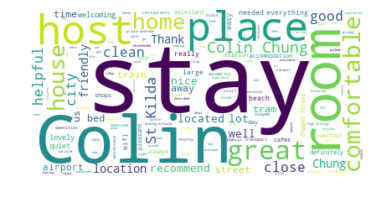

In [217]:
createWordCloud(16760)

In [306]:
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML


init_notebook_mode(connected=True)


years = x["year"].unique().astype(str)
# make list of continents
cities = x["city"].unique()

# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0,5], 'title': 'Nb of visitor', 'type':'log'}
figure['layout']['yaxis'] = {'range': [80,300],'title': 'Price'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Year:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1952
for city in cities:
    dataset_by_year = x[x['year'] == year]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['city'] == city]

    data_dict = {
        'x': list(dataset_by_year_and_cont['visitor']),
        'y': list(dataset_by_year_and_cont['price']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['city']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 1,
            'size': list(dataset_by_year_and_cont['size'])
        },
        'name': city
    }
    figure['data'].append(data_dict)
    
# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for city in cities:
        dataset_by_year = x[x['year'] == int(year)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['city'] == city]

        data_dict = {
            'x': list(dataset_by_year_and_cont['visitor']),
            'y': list(dataset_by_year_and_cont['price']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['city']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 1,
                'size': list(dataset_by_year_and_cont['size'])
            },
            'name': city
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]
iplot(figure)